In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_most_similar_column(df, query):
    vectorizer = TfidfVectorizer().fit(df.columns)
    vectorized_query = vectorizer.transform([query])
    column_vectors = vectorizer.transform(df.columns)
    similarity_scores = cosine_similarity(column_vectors, vectorized_query)
    most_similar_column = df.columns[np.argmax(similarity_scores)]
    return most_similar_column

def analyze_column(csv_path, query):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Get the most similar column to the query
    most_similar_column = get_most_similar_column(df, query)

    # Get the statistics of the most similar column, including "N/A" (NaN) values
    column_statistics = df[most_similar_column].value_counts(dropna=False)
    
    return column_statistics

In [4]:

csv_path = ['ICLR2019data.csv', 'ICLR2020data.csv', 'ICLR2021data.csv', 'ICLR2022data.csv']
query = 'Decision'
for i in csv_path:
    column_stats = analyze_column(i, query)
    print(i + "\n",column_stats)
# Oral>Spotlight>Poster>Reject>Censored(NaN or Unknown)

ICLR2019data.csv
 Reject             917
Accept (Poster)    478
NaN                146
Accept (Oral)       24
Name: Decision, dtype: int64
ICLR2020data.csv
 Reject                1526
Accept (Poster)        532
NaN                    348
Accept (Spotlight)     107
Accept (Talk)           48
Name: Decision, dtype: int64
ICLR2021data.csv
 Reject                1755
Accept (Poster)        693
Unknown                350
Accept (Spotlight)     114
Accept (Oral)           53
Name: Decision, dtype: int64
ICLR2022data.csv
 Reject                1580
Accept (Poster)        865
Unknown                587
Accept (Spotlight)     176
Accept (Oral)           54
Name: Decision, dtype: int64


In [5]:

def analyze_column_num(csv_path, query):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Get the most similar column to the query
    most_similar_column = get_most_similar_column(df, query)

    # Get the statistics of the most similar column
    min_value = df[most_similar_column].min()
    max_value = df[most_similar_column].max()
    avg_value = df[most_similar_column].mean()
    
    print(csv_path)
    print(f"Min Value: {min_value}")
    print(f"Max Value: {max_value}")
    print(f"Average Value: {avg_value}")
    
query = 'AvgRating'
for i in csv_path:
    analyze_column_num(i, query)

ICLR2019data.csv
Min Value: 1.5
Max Value: 8.67
Average Value: 5.321246006389776
ICLR2020data.csv
Min Value: 1.0
Max Value: 8.0
Average Value: 4.180640374853573
ICLR2021data.csv
Min Value: 2.0
Max Value: 8.75
Average Value: 5.369996627318718
ICLR2022data.csv
Min Value: 1.0
Max Value: 9.0
Average Value: 5.248301655426118


Model accuracy: 0.9122807017543859
Confusion Matrix:
[[348  29]
 [ 16 120]]


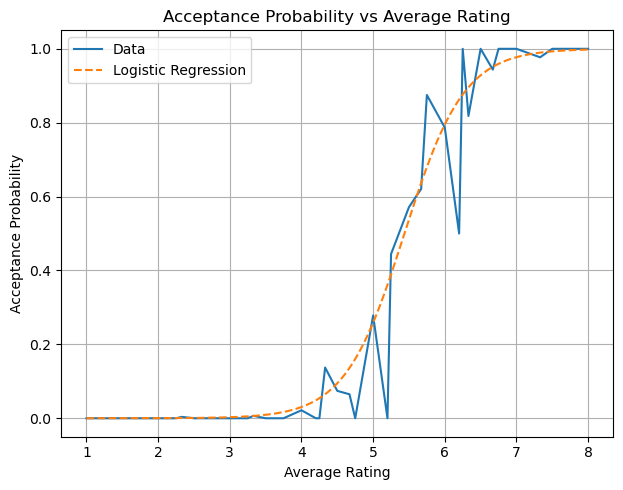

In [73]:

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def compute_acceptance_probability(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Get the most similar column to "average rating" and "decision"
    rating_column = get_most_similar_column(df, "AvgRating")
    decision_column = get_most_similar_column(df, "decision")

    # Compute the acceptance count and total count for each unique rating
    df['accepted'] = df[decision_column].apply(lambda x: 'ccept' in str(x).lower())
    df['rejected'] = df[decision_column].apply(lambda x: 'reject' in str(x).lower())
    accept_counts = df.groupby(rating_column)['accepted'].sum()
    total_counts = df.groupby(rating_column)['accepted'].count()

    # Compute the acceptance probability for each unique rating
    acceptance_probability = accept_counts / total_counts

    return acceptance_probability, df[rating_column], df['accepted']

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

def plot_acceptance_probability(csv_path):
    acceptance_probability, X, y = compute_acceptance_probability(csv_path)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit logistic regression model
    model = LogisticRegression()
    X_train = np.array(X_train).reshape(-1, 1)
    y_train = np.array(y_train)
    model.fit(X_train, y_train)

    # Predict on test data
    X_test = np.array(X_test).reshape(-1, 1)
    y_pred = model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy}")
    
    # Compute and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Predict probabilities for a range of rating values
    X_range = np.linspace(min(X), max(X), 300).reshape(-1, 1)
    y_range_pred = model.predict_proba(X_range)[:, 1]
    
    # Plot the acceptance probability as a function of rating
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acceptance_probability.index, acceptance_probability.values, label='Data')
    plt.plot(X_range, y_range_pred, label='Logistic Regression', linestyle='dashed')
    plt.xlabel('Average Rating')
    plt.ylabel('Acceptance Probability')
    plt.title('Acceptance Probability vs Average Rating')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage
plot_acceptance_probability('ICLR2020data.csv')

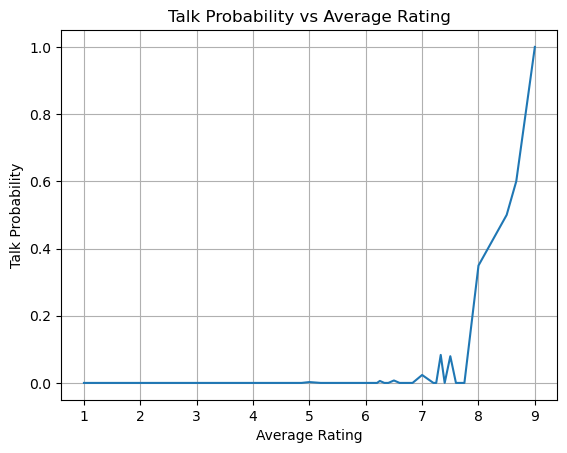

In [71]:

def compute_talk_probability(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Get the most similar column to "average rating" and "decision"
    rating_column = get_most_similar_column(df, "AvgRating")
    decision_column = get_most_similar_column(df, "decision")

    # Compute the talk count and total count for each unique rating
    df['talk'] = df[decision_column].apply(lambda x: 'oral' in str(x).lower() or 'talk' in str(x).lower())
    df['rejected_or_unknown'] = df[decision_column].apply(lambda x: 'reject' in str(x).lower() or 'unknown' in str(x).lower() or pd.isna(x))
    talk_counts = df.groupby(rating_column)['talk'].sum()
    total_counts = df.groupby(rating_column)['talk'].count() + df.groupby(rating_column)['rejected_or_unknown'].sum()

    # Compute the talk probability for each unique rating
    talk_probability = talk_counts / total_counts

    return talk_probability

def plot_talk_probability(csv_path):
    talk_probability = compute_talk_probability(csv_path)
    
    # Plot the talk probability as a function of rating
    plt.plot(talk_probability.index, talk_probability.values)
    plt.xlabel('Average Rating')
    plt.ylabel('Talk Probability')
    plt.title('Talk Probability vs Average Rating')
    plt.grid(True)
    plt.show()

# Usage
plot_talk_probability('ICLR2022data.csv')

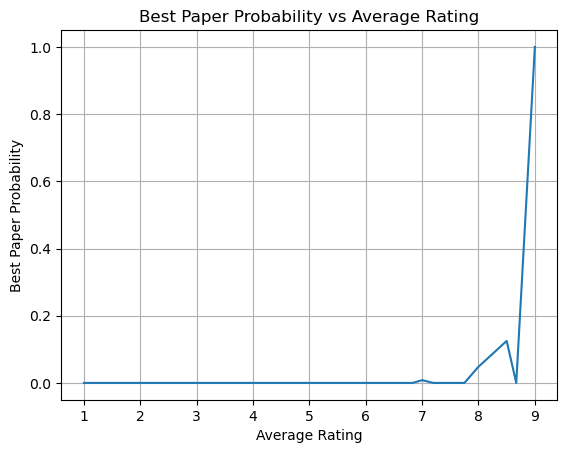

In [54]:

def compute_best_paper_probability(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Get the most similar column to "average rating" and "best paper"
    rating_column = get_most_similar_column(df, "AvgRating")
    best_paper_column = get_most_similar_column(df, "best paper")

    # Compute the best paper count and total count for each unique rating
    best_paper_counts = df.groupby(rating_column)[best_paper_column].sum()
    total_counts = df.groupby(rating_column)[best_paper_column].count()

    # Compute the best paper probability for each unique rating
    best_paper_probability = best_paper_counts / total_counts

    return best_paper_probability

def plot_best_paper_probability(csv_path):
    best_paper_probability = compute_best_paper_probability(csv_path)
    
    # Plot the best paper probability as a function of rating
    plt.plot(best_paper_probability.index, best_paper_probability.values)
    plt.xlabel('Average Rating')
    plt.ylabel('Best Paper Probability')
    plt.title('Best Paper Probability vs Average Rating')
    plt.grid(True)
    plt.show()

# Usage
plot_best_paper_probability('ICLR2022data.csv')

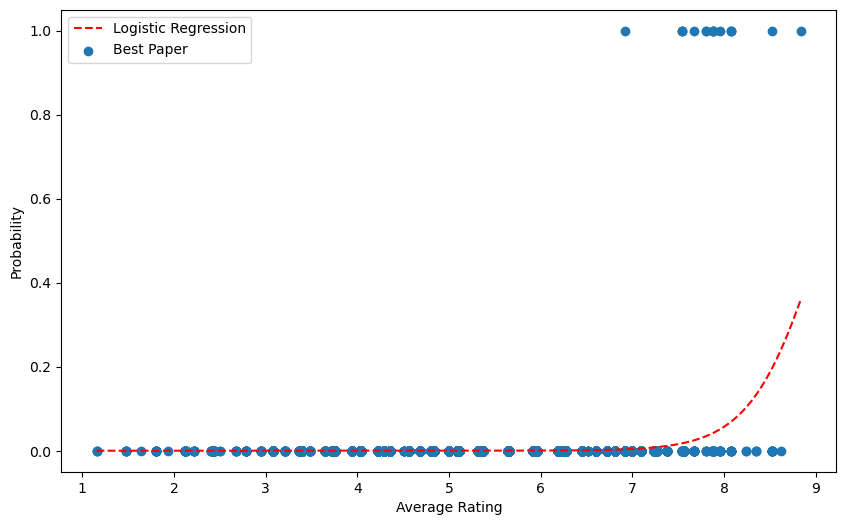

In [63]:

import seaborn as sns

csv_path_best = ['ICLR2019data.csv', 'ICLR2021data.csv', 'ICLR2022data.csv']

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.linear_model import LogisticRegression

def plot_all_best_paper_probability_with_logistic_regression(csv_paths, bins=25):
    all_data = []
    mid_points = []  # mid point of each bin
    best_paper_results = []
    for csv_path in csv_paths:
        # Read the CSV file
        df = pd.read_csv(csv_path)

        # Get the most similar column to the query
        rating_col = get_most_similar_column(df, "AvgRating")
        best_paper_col = get_most_similar_column(df, "best paper")
        
        # We just keep the necessary columns and append them to the all_data list
        df = df[[rating_col, best_paper_col]]
        all_data.append(df)

        # Discretize the rating column into bins
        df['rating_bin'] = pd.cut(df[rating_col], bins)

        # Calculate accept/reject numbers for each rating bin
        rating_bins = df['rating_bin'].unique()
        rating_bins = sorted(rating_bins, key=lambda x: x.left)  # sort the bins from low to high

        for rating_bin in rating_bins:
            df_bin = df[df['rating_bin'] == rating_bin]
            best_paper_results.extend(df_bin[best_paper_col].tolist())
            mid_points.extend([((rating_bin.left + rating_bin.right) / 2)] * len(df_bin))
            
    # Prepare the data for logistic regression
    X = np.array(mid_points).reshape(-1, 1)
    Y = np.array(best_paper_results)

    # Fit a logistic regression model
    model = LogisticRegression()
    model.fit(X, Y)  # no need to round the probabilities to get binary values

    # Predict with the model
    X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    Y_pred = model.predict_proba(X_test)[:, 1]

    # Plot the accept probability and the logistic regression curve
    plt.figure(figsize=(10,6))
    plt.scatter(X, Y, label='Best Paper')
    plt.plot(X_test, Y_pred, label='Logistic Regression', linestyle='dashed', color='red')
    plt.xlabel('Average Rating')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()
    
    
# Usage
plot_all_best_paper_probability_with_logistic_regression(csv_path_best)



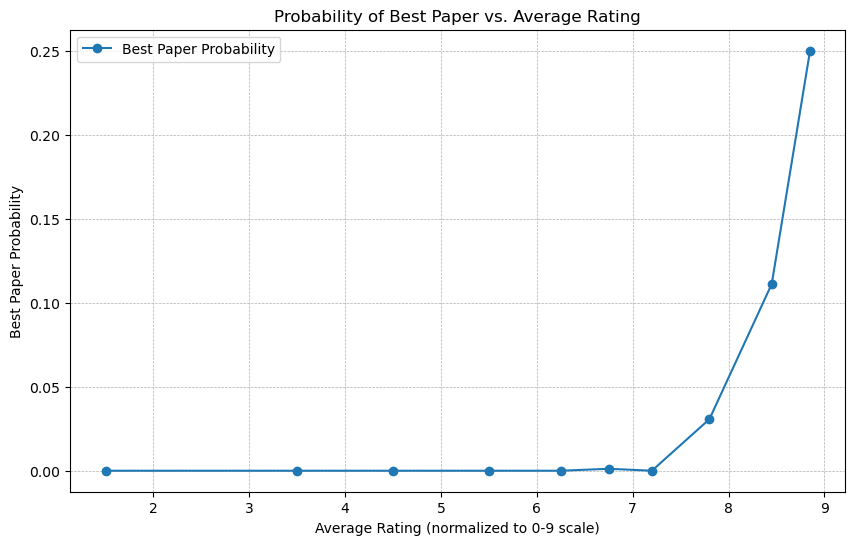

In [8]:

import seaborn as sns

csv_path_best = ['ICLR2019data.csv', 'ICLR2021data.csv', 'ICLR2022data.csv']

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

def plot_all_best_paper_probability_traditional_normalized_corrected(csv_paths, bin_edges):
    all_data = []
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        
        # Get the relevant columns
        rating_col = get_most_similar_column(df, "AvgRating")
        best_paper_col = get_most_similar_column(df, "best paper")
        
        # Normalize the ratings based on the maximum rating in each dataset
        max_rating = df[rating_col].max()
        df[rating_col] = (df[rating_col] / max_rating) * 9
        
        # Extract necessary columns and append to the list
        df = df[[rating_col, best_paper_col]]
        all_data.append(df)

    # Concatenate all dataframes into one
    data = pd.concat(all_data)
    
    # Discretize the rating column into bins
    data['rating_bin'] = pd.cut(data[rating_col], bins=bin_edges)
    
    # Calculate best paper probability for each rating bin
    rating_bins = data['rating_bin'].unique()
    rating_bins = sorted(rating_bins, key=lambda x: x.left)
    best_paper_probability = []
    avg_rating_bins = []
    for rating_bin in rating_bins:
        df_bin = data[data['rating_bin'] == rating_bin]
        accept_count = df_bin[df_bin[best_paper_col] == 1].shape[0]
        total_count = df_bin.shape[0]
        probability = accept_count / total_count
        best_paper_probability.append(probability)
        avg_rating_bins.append((rating_bin.left + rating_bin.right) / 2)
    
    # Plot the curve
    plt.figure(figsize=(10,6))
    plt.plot(avg_rating_bins, best_paper_probability, label='Best Paper Probability', marker='o')
    plt.xlabel('Average Rating (normalized to 0-9 scale)')
    plt.ylabel('Best Paper Probability')
    plt.title('Probability of Best Paper vs. Average Rating')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# User provided bin edges
bin_edges = [0, 3, 4, 5, 6, 6.5, 7, 7.4, 8.2, 8.7, 9]

# Plotting using the provided bin edges
plot_all_best_paper_probability_traditional_normalized_corrected(csv_path_best, bin_edges)


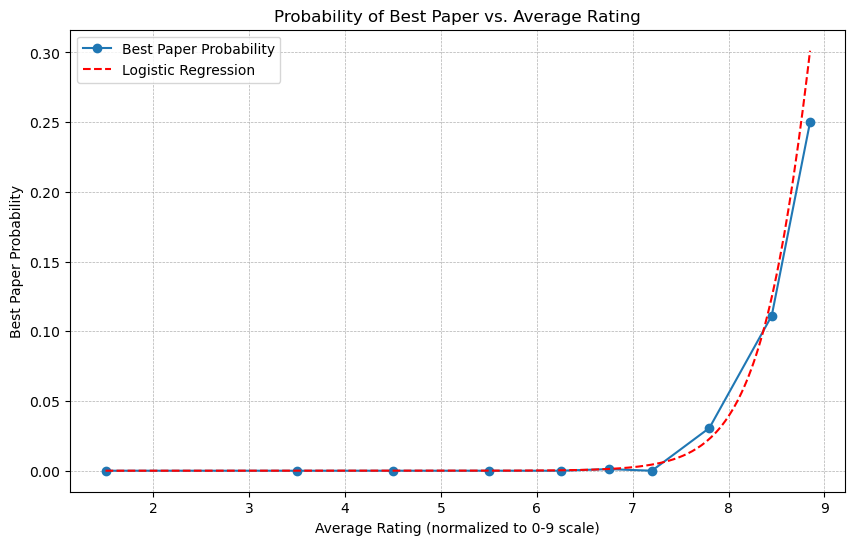

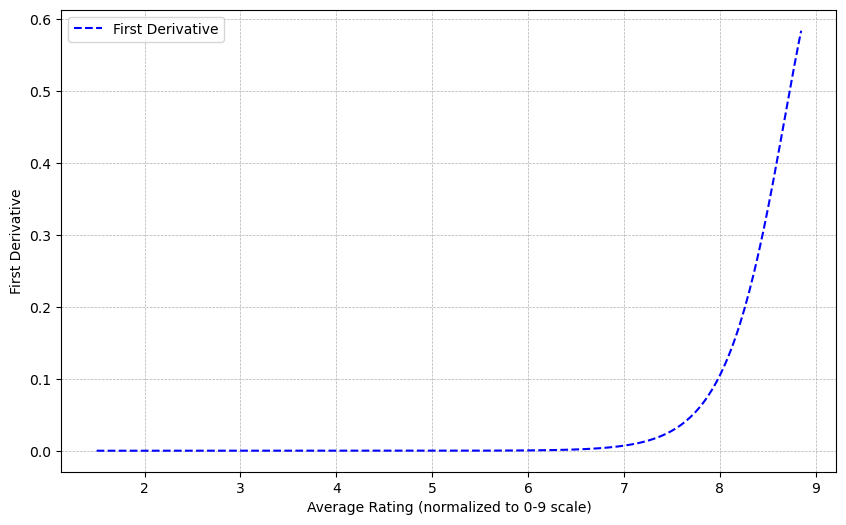

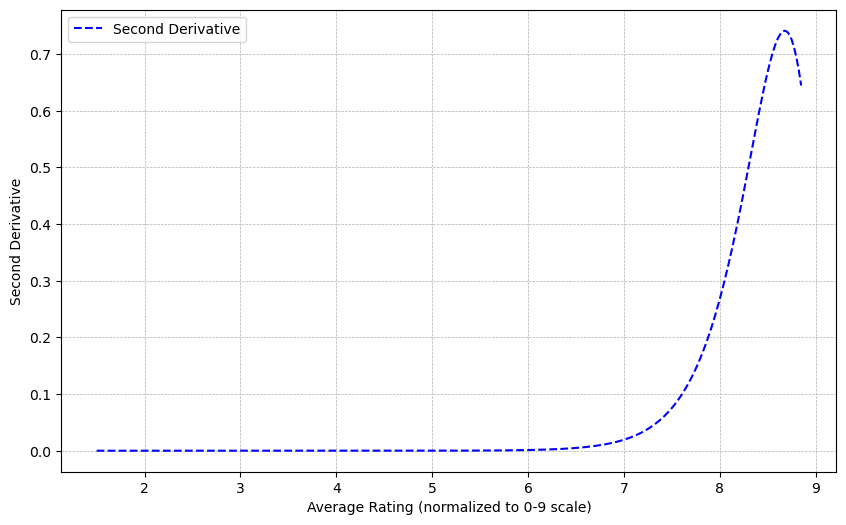

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def plot_all_best_paper_probability_with_logistic_regression(csv_paths, bin_edges):
    all_data = []
    mid_points = []  # mid point of each bin
    best_paper_results = []

    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        
        # Get the relevant columns
        rating_col = get_most_similar_column(df, "AvgRating")
        best_paper_col = get_most_similar_column(df, "best paper")
        
        # Normalize the ratings based on the maximum rating in each dataset
        max_rating = df[rating_col].max()
        df[rating_col] = (df[rating_col] / max_rating) * 9
        
        # Extract necessary columns and append to the list
        df = df[[rating_col, best_paper_col]]
        all_data.append(df)

        # Discretize the rating column into bins
        df['rating_bin'] = pd.cut(df[rating_col], bins=bin_edges)
        
        # Calculate mid points and best paper results for logistic regression
        rating_bins = df['rating_bin'].unique()
        rating_bins = sorted(rating_bins, key=lambda x: x.left)  # sort the bins from low to high

        for rating_bin in rating_bins:
            df_bin = df[df['rating_bin'] == rating_bin]
            best_paper_results.extend(df_bin[best_paper_col].tolist())
            mid_points.extend([((rating_bin.left + rating_bin.right) / 2)] * len(df_bin))
    
    # Prepare the data for logistic regression
    X = np.array(mid_points).reshape(-1, 1)
    Y = np.array(best_paper_results)

    # Fit a logistic regression model
    model = LogisticRegression(C=3)
    model.fit(X, Y)  # no need to round the probabilities to get binary values

    # Predict with the model
    X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    Y_pred = model.predict_proba(X_test)[:, 1]

    # Concatenate all dataframes into one for the first plot
    data = pd.concat(all_data)
    
    # Discretize the rating column into bins
    data['rating_bin'] = pd.cut(data[rating_col], bins=bin_edges)
    
    # Calculate best paper probability for each rating bin
    rating_bins = data['rating_bin'].unique()
    rating_bins = sorted(rating_bins, key=lambda x: x.left)
    best_paper_probability = []
    avg_rating_bins = []
    for rating_bin in rating_bins:
        df_bin = data[data['rating_bin'] == rating_bin]
        accept_count = df_bin[df_bin[best_paper_col] == 1].shape[0]
        total_count = df_bin.shape[0]
        probability = accept_count / total_count
        best_paper_probability.append(probability)
        avg_rating_bins.append((rating_bin.left + rating_bin.right) / 2)
    
    # Plot the curve
    plt.figure(figsize=(10,6))
    plt.plot(avg_rating_bins, best_paper_probability, label='Best Paper Probability', marker='o')
    plt.plot(X_test, Y_pred, label='Logistic Regression', linestyle='dashed', color='red')
    plt.xlabel('Average Rating (normalized to 0-9 scale)')
    plt.ylabel('Best Paper Probability')
    plt.title('Probability of Best Paper vs. Average Rating')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # Calculate the first and second derivatives
    beta = model.coef_[0][0]
    Y_derivative_1st = beta * Y_pred * (1 - Y_pred)
    Y_derivative_2nd = beta * Y_derivative_1st * (1 - 2 * Y_pred)

    # Plot the first derivative
    plt.figure(figsize=(10,6))
    plt.plot(X_test, Y_derivative_1st, label='First Derivative', linestyle='dashed', color='blue')
    plt.xlabel('Average Rating (normalized to 0-9 scale)')
    plt.ylabel('First Derivative')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
    # Plot the second derivative
    plt.figure(figsize=(10,6))
    plt.plot(X_test, Y_derivative_2nd, label='Second Derivative', linestyle='dashed', color='blue')
    plt.xlabel('Average Rating (normalized to 0-9 scale)')
    plt.ylabel('Second Derivative')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

bin_edges = [0, 3, 4, 5, 6, 6.5, 7, 7.4, 8.2, 8.7, 9]
    
# Usage
csv_path_best = ['ICLR2019data.csv', 'ICLR2021data.csv', 'ICLR2022data.csv']
plot_all_best_paper_probability_with_logistic_regression(csv_path_best, bin_edges)
